### Завантаження даних

In [1]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 25s 6us/step


### Аналіз даних

In [2]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


Бачимо, що маємо 60000 тисяч зображень розміром 28х28 пікселів у тренувальному датасеті та 10000 тисяч зображень такого самого розміру в тестовому наборі. Ці дані подані у вигляді матриць, що заповнені числами від 0 до 255, які позначають, яким кольором зафарбовані пікселі

In [5]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Маємо 10 вихідних класів, що мають мітки від 0 до 9

Text(0.5, 1.0, 'Ground Truth : 9')

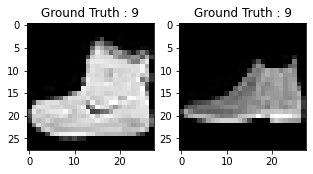

In [9]:
plt.figure(figsize=[5,5])
# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))
# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

Тут можна побачити, що перше зображення як тренувального, так і тестового набору має мітку класу "9", яка скоріш за все відповідає за взуття. Зображення подані у відтінках сірого, проте це можна змінити прибиранням або зміною на певне значення параметра `cmap`

### Попередня обробка даних

In [10]:
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Перетворили дані зображень тренувального і тестового набору розміром 28x28 у матрицю розміром 28x28x1, яка може подаватися в мережу. Але дані тепер треба станндартизувати.

In [11]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

Стандартизували дані (також для цього можна було використати `MinMaxScaler`)

In [12]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Провели векторизацію початкових даних. Бачимо, що оскільки перше зображення мало мітку 9 класу, то вектор кодування такий `[0 0 0 0 0 0 0 0 0 1]`

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
train_Y_one_hot, test_size=0.2, random_state=13)
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

Розбили початковий тренувальний набір на тренувальний та валідаційний у відношенні 4:1. Не забуваємо, що також існує тестовий набір, в якому 10000 строчок розміченних даних. Тож маємо таке відношення розмірів тренувального, валідаційного та тестового наборів: 24:6:5

## Нейронна мережа

### Моделювання даних

In [27]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU


batch_size = 64
epochs = 20
num_classes = 10

### Архітектура нейронної мережі

In [28]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3,3), 
activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(Dense(num_classes, activation='softmax'))

### Компіляція моделі


In [31]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, \
                      optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
fashion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

Отримали візуалізацію шарів нейронної мережі, а також значення параметрвів. Бачимо що `Total params: 356,234`, `Trainable params: 356,234`, `Non-trainable params: 0`. Тут ми передаємо в нейронну мережу масив розміром 28х28х1, а на виході отримуємо масив розміром 10, що і було передбачувано, а також задано в архітектурі самої нейронної мережі

### Тренування моделі

In [32]:
fashion_train = fashion_model.fit(train_X, train_label,
batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X,
valid_label))

Epoch 1/20
750/750 [==============================] - 52s 68ms/step - loss: 0.4647 - accuracy: 0.8318 - val_loss: 0.3235 - val_accuracy: 0.8834
Epoch 2/20
750/750 [==============================] - 52s 69ms/step - loss: 0.2827 - accuracy: 0.8976 - val_loss: 0.2744 - val_accuracy: 0.9000
Epoch 3/20
750/750 [==============================] - 55s 74ms/step - loss: 0.2363 - accuracy: 0.9132 - val_loss: 0.2400 - val_accuracy: 0.9120
Epoch 4/20
750/750 [==============================] - 49s 65ms/step - loss: 0.2044 - accuracy: 0.9248 - val_loss: 0.2437 - val_accuracy: 0.9101
Epoch 5/20
750/750 [==============================] - 54s 71ms/step - loss: 0.1803 - accuracy: 0.9337 - val_loss: 0.2533 - val_accuracy: 0.9081
Epoch 6/20
750/750 [==============================] - 56s 75ms/step - loss: 0.1559 - accuracy: 0.9414 - val_loss: 0.2282 - val_accuracy: 0.9177
Epoch 7/20
750/750 [==============================] - 53s 71ms/step - loss: 0.1387 - accuracy: 0.9482 - val_loss: 0.2323 - val_accuracy:

Навчили модель протягом 20 епох. Бачимо, що отримана точність 0.9897, а втрати навчання 0.0355, проте втрата валідації доволі висока 0.4428, а точність на валідаційних даних 0.9215. Можемо, зробити висновок, що отримана модель трошки перенавчана, що можна виправити додаванням шару Dropout

In [33]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.4663892984390259
Test accuracy: 0.9211999773979187


На тестовому наборі точність приблизно така сама, як і на валідаційному. Більш того, значення втрат приблизно однакова. Хоч точність доволі висока як для класифікатора на 10 класів, проте модель трохи перенавчена, тому її можна покращувати

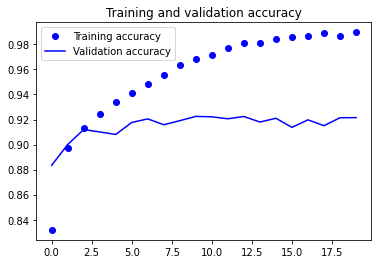

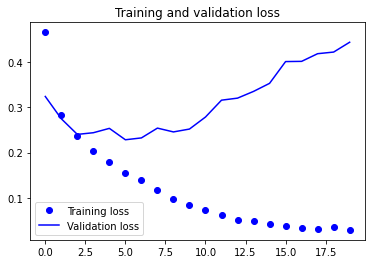

In [37]:
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Бачимо, що точність на валідаційних даних перестала зростати після певного моменту (4-5 епохи), при цьому втрата валідації почала рости. Це явна ознака перенавчання. Покращимо нашу модель

### Додавання Dropout до нейронної мережі


In [38]:
batch_size = 64
epochs = 20
num_classes = 10
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3,
3),activation='linear',padding='same',input_shape=(28,28,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax'))
fashion_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                      

В отриманій архітектурі майже нічого, окрім додавання трьох вимикаючих шарів, не змінилося

In [39]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
fashion_train_dropout = fashion_model.fit(train_X, train_label,
batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 60s 79ms/step - loss: 0.6050 - accuracy: 0.7750 - val_loss: 0.3644 - val_accuracy: 0.8672
Epoch 2/20
750/750 [==============================] - 57s 76ms/step - loss: 0.3736 - accuracy: 0.8635 - val_loss: 0.3117 - val_accuracy: 0.8852
Epoch 3/20
750/750 [==============================] - 59s 79ms/step - loss: 0.3275 - accuracy: 0.8786 - val_loss: 0.2784 - val_accuracy: 0.8974
Epoch 4/20
750/750 [==============================] - 60s 81ms/step - loss: 0.2962 - accuracy: 0.8891 - val_loss: 0.2755 - val_accuracy: 0.9003
Epoch 5/20
750/750 [==============================] - 63s 84ms/step - loss: 0.2801 - accuracy: 0.8957 - val_loss: 0.2455 - val_accuracy: 0.9083
Epoch 6/20
750/750 [==============================] - 62s 83ms/step - loss: 0.2651 - accuracy: 0.9004 - val_loss: 0.2359 - val_accuracy: 0.9126
Epoch 7/20
750/750 [==============================] - 59s 79ms/step - loss: 0.2548 - accuracy: 0.9044 - val_loss: 0.2315 - val_accuracy:

Бачимо, що таким чином змогли зменшити втрати на валідаційному наборі та позбавитись перенавчання, проте точність моделі від цього не покращилась

In [40]:
fashion_model.save("fashion_model_dropout.h5py")

INFO:tensorflow:Assets written to: fashion_model_dropout.h5py\assets


INFO:tensorflow:Assets written to: fashion_model_dropout.h5py\assets


In [42]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.2266 - accuracy: 0.9170
Test loss: 0.22658789157867432
Test accuracy: 0.9169999957084656


Втрати на тестовому наборі суттєво зменшиися, проте це не дало покращення точності моделі

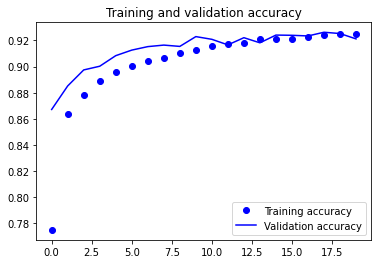

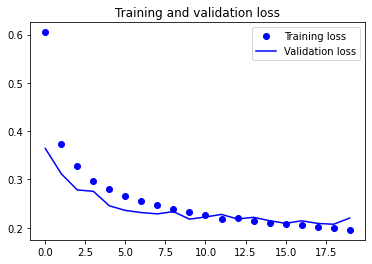

In [44]:
accuracy = fashion_train_dropout.history['accuracy']
val_accuracy = fashion_train_dropout.history['val_accuracy']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Бачимо тепер, що втрати та точність на валідаційному сеті синхронізуються з цими самими метриками на тренувальному.
Таким чином, здатність моделі до узагальнення стала набагато кращою, 
оскільки втрата як тестового набору, так і набору перевірки була лише трохи 
більше в порівнянні з втратою навчання.

### Прогнозування міток


In [45]:
predicted_classes = fashion_model.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_Y.shape

313/313 [==============================] - 2s 7ms/step


((10000,), (10000,))

Отримали прогнозування для тестового набору даних. Форма прогнозування співпадає з формою масива міток, тобто таким чином можна перевірити коректність моделі

Found 9130 correct labels


C:\Users\shink\AppData\Local\Temp/ipykernel_8412/1607187239.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


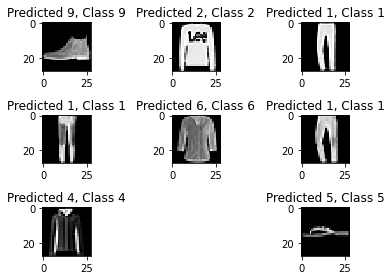

In [47]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray',interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct],
    test_Y[correct]))
    plt.tight_layout()

Отримали 9130 точних прогнозів з 10000 можливих, тобто точність сягає 91,3% . Бачимо також перші 9 коректно розпізнаних зображень.

Found 870 incorrect labels


C:\Users\shink\AppData\Local\Temp/ipykernel_8412/3660219251.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


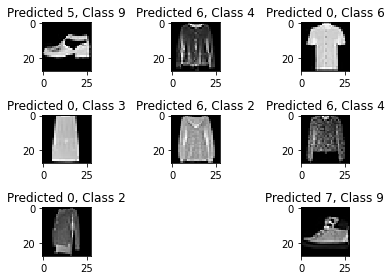

In [49]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray',
    interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect],
    test_Y[incorrect]))
    plt.tight_layout()

Отримали 870 неправильних прогнозів з 10000 можливих, тобто модель помиляється в 8,7% випадках. Бачимо також перші 9 хибно розпізнаних зображень.

### Звіт про класифікацію


In [50]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.77      0.90      0.83      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.83      0.91      0.87      1000
     Class 3       0.91      0.93      0.92      1000
     Class 4       0.90      0.79      0.84      1000
     Class 5       0.99      0.98      0.98      1000
     Class 6       0.83      0.70      0.76      1000
     Class 7       0.96      0.98      0.97      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



Бачимо, що найчастыше подель помиляється на об'єктах класу 6, а найкраще розпізнає об'єкти класів 1 і 8

## Висновки

У ході виконання цієї роботи засобами бібліотек мови програмування Python було виконано завантаження, дослідження та аналіз набору даних, змінено розмір та масштаб зображень, перетворено мітки даних у вектори для подальшого кодування, розділкно дані на набори для навчання та тестування моделі; побудувано модель нейронної мережі CNN: навчена та оцінена побудованп модель, побудувані графіки 
точності та втрат; оцінена новп модель та порівняно результати; зроблені
прогнози щодо даних випробувань, перетворені ймовірності у мітки класів і 
побудувані тестові зразки, які модель класифікує правильно, візуалізувано 
звіт про класифікацію даних. 